# Visualising trials from Fast AutoAugment

In this notebook, I aim to understand how Fast AutoAugment found the optimal data augmentation policies for CIFAR-10.

In the bayesian optimization loop I designed, at each round, the evaluation function receives a policy that has 5 sub-policies. The function saves the sub-policy and its validation loss to Trials. I'm going to delve into the Trials and visualize the relationship between validation error (that we are aiming to minimize) and operations.

To focus on an operation at a time, I turned policy-error pairs into operation-error pairs. This might weaken the interpretation but it shows the general trend. 

Plus, I compared the distribution of the operations I found in my optimal policy to the ones of the official implementation by Kakao Brain. The official version seems to cover wider ranges of probabilities and magnitudes whereas my policy tends to focus on narrower regions as shown in Invert and Rotate.

In [1]:
import os
import pickle
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from search_fastautoaugment import parse_trial_records

In [2]:
cv_folds = 5
search_width = 2
search_results_folder = 'fastautoaugment'

In [3]:
augmentation_list_to_explore = {
        'ShearX': [-0.3, 0.3],
        'ShearY': [-0.3, 0.3],
        'TranslateX': [-0.45, 0.45],
        'TranslateY': [-0.45, 0.45],
        'Rotate': [-30, 30],
        'AutoContrast': None,
        'Invert': None,
        'Equalize': None,
        'Solarize': [0, 256],
        'Posterize': [4, 8],
        'Contrast': [0.1, 1.9],
        'Color': [0.1, 1.9],
        'Brightness': [0.1, 1.9],
        'Sharpness': [0.1, 1.9],
        'Cutout': [0.0, 0.2]
}

In [4]:
records = []

for k_idx in range(cv_folds):

    T_star_k_idx = []

    for t_idx in range(search_width):
        trials = pickle.load(
            open(os.path.join(search_results_folder, "k{}_t{}_trials.pkl".format(k_idx, t_idx)), "rb"))

        val_error_list = [t['result']['loss'] for t in trials.trials]
        trial_records = [t['misc']['vals'] for t in trials.trials]
        parsed_policies = parse_trial_records(trial_records, 5, 2, augmentation_list_to_explore)
        zipped = zip(parsed_policies, val_error_list)
        for policy, error in zipped:
            for sub_policy in policy:
                for operation in sub_policy:
                    records.append({"op_name": operation[0],
                                   "op_type":"p",
                                   "val": operation[1],
                                   "loss": error})
                    records.append({"op_name": operation[0],
                                   "op_type":"v",
                                   "val": operation[2],
                                   "loss": error})

In [5]:
records_df = pd.DataFrame(records)
pivoted = pd.pivot_table(records_df, index=['op_name', 'loss'], columns='op_type').reset_index()

In [6]:
optimal_policy = pickle.load(open(os.path.join(search_results_folder, "optimal_policy.pkl"), "rb"))

optimal_policy_dict = defaultdict()
for aug_fn in list(augmentation_list_to_explore.keys()):
    optimal_policy_dict[aug_fn] = {'p': [], 'v': []}

for sub_policy in optimal_policy:
    for op in sub_policy:
        optimal_policy_dict[op[0]]['p'].append(op[1])
        optimal_policy_dict[op[0]]['v'].append(op[2])

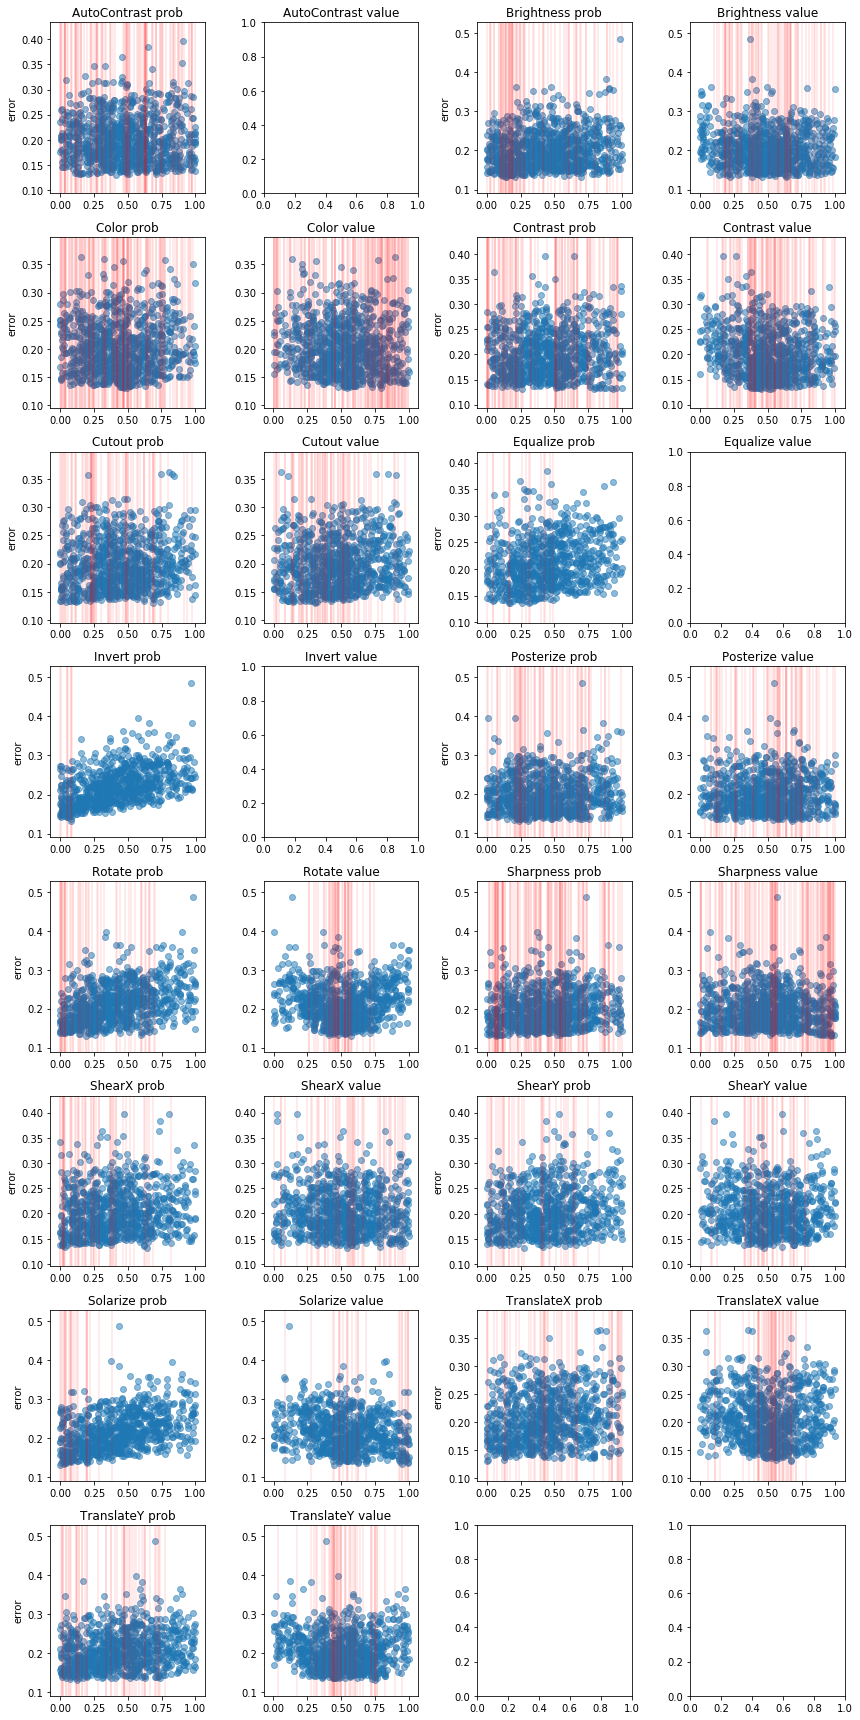

In [7]:
g = pivoted.groupby('op_name')

fig, ax = plt.subplots(8, 4, figsize=(12, 24), facecolor='white')

for idx, (label, data) in enumerate(g):
    
    nrow = idx // 2
    isEven = int((idx+1) % 2 == 0)
    
    ax[nrow, isEven*2].scatter(data.val.p, data.loss, alpha=0.5)
    for p in optimal_policy_dict[label]['p']:
        ax[nrow, isEven*2].axvline(p, 0, 1, color='red', alpha=0.1)
    
    if augmentation_list_to_explore[label]:
        ax[nrow, isEven*2+1].scatter(data.val.v, data.loss, alpha=0.5)
        for v in optimal_policy_dict[label]['v']:
            ax[nrow, isEven*2+1].axvline(v, 0, 1, color='red', alpha=0.1)
    ax[nrow, isEven*2].set_title(label + " prob")
    ax[nrow, isEven*2+1].set_title(label + " value")
    
    ax[nrow, isEven*2].set_ylabel("error")
    
plt.tight_layout()    
plt.show()

In [8]:
# Reference: https://github.com/kakaobrain/fast-autoaugment/blob/master/FastAutoAugment/archive.py
def fa_reduced_cifar10():
    p = [[["Contrast", 0.8320659688593578, 0.49884310562180767], ["TranslateX", 0.41849883971249136, 0.394023086494538]], [["Color", 0.3500483749890918, 0.43355143929883955], ["Color", 0.5120716140300229, 0.7508299643325016]], [["Rotate", 0.9447932604389472, 0.29723465088990375], ["Sharpness", 0.1564936149799504, 0.47169309978091745]], [["Rotate", 0.5430015349185097, 0.6518626678905443], ["Color", 0.5694844928020679, 0.3494533005430269]], [["AutoContrast", 0.5558922032451064, 0.783136004977799], ["TranslateY", 0.683914191471972, 0.7597025305860181]], [["TranslateX", 0.03489224481658926, 0.021025488042663354], ["Equalize", 0.4788637403857401, 0.3535481281496117]], [["Sharpness", 0.6428916269794158, 0.22791511918580576], ["Contrast", 0.016014045073950323, 0.26811312269487575]], [["Rotate", 0.2972727228410451, 0.7654251516829896], ["AutoContrast", 0.16005809254943348, 0.5380523650108116]], [["Contrast", 0.5823671057717301, 0.7521166301398389], ["TranslateY", 0.9949449214751978, 0.9612671341689751]], [["Equalize", 0.8372126687702321, 0.6944127225621206], ["Rotate", 0.25393282929784755, 0.3261658365286546]], [["Invert", 0.8222011603194572, 0.6597915864008403], ["Posterize", 0.31858707654447327, 0.9541013715579584]], [["Sharpness", 0.41314621282107045, 0.9437344470879956], ["Cutout", 0.6610495837889337, 0.674411664255093]], [["Contrast", 0.780121736705407, 0.40826152397463156], ["Color", 0.344019192125256, 0.1942922781355767]], [["Rotate", 0.17153139555621344, 0.798745732456474], ["Invert", 0.6010555860501262, 0.320742172554767]], [["Invert", 0.26816063450777416, 0.27152062163148327], ["Equalize", 0.6786829200236982, 0.7469412443514213]], [["Contrast", 0.3920564414367518, 0.7493644582838497], ["TranslateY", 0.8941657805606704, 0.6580846856375955]], [["Equalize", 0.875509207399372, 0.9061130537645283], ["Cutout", 0.4940280679087308, 0.7896229623628276]], [["Contrast", 0.3331423298065147, 0.7170041362529597], ["ShearX", 0.7425484291842793, 0.5285117152426109]], [["Equalize", 0.97344237365026, 0.4745759720473106], ["TranslateY", 0.055863458430295276, 0.9625142022954672]], [["TranslateX", 0.6810614083109192, 0.7509937355495521], ["TranslateY", 0.3866463019475701, 0.5185481505576112]], [["Sharpness", 0.4751529944753671, 0.550464012488733], ["Cutout", 0.9472914750534814, 0.5584925992985023]], [["Contrast", 0.054606784909375095, 0.17257080196712182], ["Cutout", 0.6077026782754803, 0.7996504165944938]], [["ShearX", 0.328798428243695, 0.2769563264079157], ["Cutout", 0.9037632437023772, 0.4915809476763595]], [["Cutout", 0.6891202672363478, 0.9951490996172914], ["Posterize", 0.06532762462628705, 0.4005246609075227]], [["TranslateY", 0.6908583592523334, 0.725612120376128], ["Rotate", 0.39907735501746666, 0.36505798032223147]], [["TranslateX", 0.10398364107399072, 0.5913918470536627], ["Rotate", 0.7169811539340365, 0.8283850670648724]], [["ShearY", 0.9526373530768361, 0.4482347365639251], ["Contrast", 0.4203947336351471, 0.41526799558953864]], [["Contrast", 0.24894431199700073, 0.09578870500994707], ["Solarize", 0.2273713345927395, 0.6214942914963707]], [["TranslateX", 0.06331228870032912, 0.8961907489444944], ["Cutout", 0.5110007859958743, 0.23704875994050723]], [["Cutout", 0.3769183548846172, 0.6560944580253987], ["TranslateY", 0.7201924599434143, 0.4132476526938319]], [["Invert", 0.6707431156338866, 0.11622795952464149], ["Posterize", 0.12075972752370845, 0.18024933294172307]], [["Color", 0.5010057264087142, 0.5277767327434318], ["Rotate", 0.9486115946366559, 0.31485546630220784]], [["ShearX", 0.31741302466630406, 0.1991215806270692], ["Invert", 0.3744727015523084, 0.6914113986757578]], [["Brightness", 0.40348479064392617, 0.8924182735724888], ["Brightness", 0.1973098763857779, 0.3939288933689655]], [["Color", 0.01208688664030888, 0.6055693000885217], ["Equalize", 0.433259451147881, 0.420711137966155]], [["Cutout", 0.2620018360076487, 0.11594468278143644], ["Rotate", 0.1310401567856766, 0.7244318146544101]], [["ShearX", 0.15249651845933576, 0.35277277071866986], ["Contrast", 0.28221794032094016, 0.42036586509397444]], [["Brightness", 0.8492912150468908, 0.26386920887886056], ["Solarize", 0.8764208056263386, 0.1258195122766067]], [["ShearX", 0.8537058239675831, 0.8415101816171269], ["AutoContrast", 0.23958568830416294, 0.9889049529564014]], [["Rotate", 0.6463207930684552, 0.8750192129056532], ["Contrast", 0.6865032211768652, 0.8564981333033417]], [["Equalize", 0.8877190311811044, 0.7370995897848609], ["TranslateX", 0.9979660314391368, 0.005683998913244781]], [["Color", 0.6420017551677819, 0.6225337265571229], ["Solarize", 0.8344504978566362, 0.8332856969941151]], [["ShearX", 0.7439332981992567, 0.9747608698582039], ["Equalize", 0.6259189804002959, 0.028017478098245174]], [["TranslateY", 0.39794770293366843, 0.8482966537902709], ["Rotate", 0.9312935630405351, 0.5300586925826072]], [["Cutout", 0.8904075572021911, 0.3522934742068766], ["Equalize", 0.6431186289473937, 0.9930577962126151]], [["Contrast", 0.9183553386089476, 0.44974266209396685], ["TranslateY", 0.8193684583123862, 0.9633741156526566]], [["ShearY", 0.616078299924283, 0.19219314358924766], ["Solarize", 0.1480945914138868, 0.05922109541654652]], [["Solarize", 0.25332455064128157, 0.18853037431947994], ["ShearY", 0.9518390093954243, 0.14603930044061142]], [["Color", 0.8094378664335412, 0.37029830225408433], ["Contrast", 0.29504113617467465, 0.065096365468442]], [["AutoContrast", 0.7075167558685455, 0.7084621693458267], ["Sharpness", 0.03555539453323875, 0.5651948313888351]], [["TranslateY", 0.5969982600930229, 0.9857264201029572], ["Rotate", 0.9898628564873607, 0.1985685534926911]], [["Invert", 0.14915939942810352, 0.6595839632446547], ["Posterize", 0.768535289994361, 0.5997358684618563]], [["Equalize", 0.9162691815967111, 0.3331035307653627], ["Color", 0.8169118187605557, 0.7653910258006366]], [["Rotate", 0.43489185299530897, 0.752215269135173], ["Brightness", 0.1569828560334806, 0.8002808712857853]], [["Invert", 0.931876215328345, 0.029428644395760872], ["Equalize", 0.6330036052674145, 0.7235531014288485]], [["ShearX", 0.5216138393704968, 0.849272958911589], ["AutoContrast", 0.19572688655120263, 0.9786551568639575]], [["ShearX", 0.9899586208275011, 0.22580547500610293], ["Brightness", 0.9831311903178727, 0.5055159610855606]], [["Brightness", 0.29179117009211486, 0.48003584672937294], ["Solarize", 0.7544252317330058, 0.05806581735063043]], [["AutoContrast", 0.8919800329537786, 0.8511261613698553], ["Contrast", 0.49199446084551035, 0.7302297140181429]], [["Cutout", 0.7079723710644835, 0.032565015538375874], ["AutoContrast", 0.8259782090388609, 0.7860708789468442]], [["Posterize", 0.9980262659801914, 0.6725084224935673], ["ShearY", 0.6195568269664682, 0.5444170291816751]], [["Posterize", 0.8687351834713217, 0.9978004914422602], ["Equalize", 0.4532646848325955, 0.6486748015710573]], [["Contrast", 0.2713928776950594, 0.15255249557027806], ["ShearY", 0.9276834387970199, 0.5266542862333478]], [["AutoContrast", 0.5240786618055582, 0.9325642258930253], ["Cutout", 0.38448627892037357, 0.21219415055662394]], [["TranslateX", 0.4299517937295352, 0.20133751201386152], ["TranslateX", 0.6753468310276597, 0.6985621035400441]], [["Rotate", 0.4006472499103597, 0.6704748473357586], ["Equalize", 0.674161668148079, 0.6528530101705237]], [["Equalize", 0.9139902833674455, 0.9015103149680278], ["Sharpness", 0.7289667720691948, 0.7623606352376232]], [["Cutout", 0.5911267429414259, 0.5953141187177585], ["Rotate", 0.5219064817468504, 0.11085141355857986]], [["TranslateX", 0.3620095133946267, 0.26194039409492476], ["Rotate", 0.3929841359545597, 0.4913406720338047]], [["Invert", 0.5175298901458896, 0.001661410821811482], ["Invert", 0.004656581318332242, 0.8157622192213624]], [["AutoContrast", 0.013609693335051465, 0.9318651749409604], ["Invert", 0.8980844358979592, 0.2268511862780368]], [["ShearY", 0.7717126261142194, 0.09975547983707711], ["Equalize", 0.7808494401429572, 0.4141412091009955]], [["TranslateX", 0.5878675721341552, 0.29813268038163376], ["Posterize", 0.21257276051591356, 0.2837285296666412]], [["Brightness", 0.4268335108566488, 0.4723784991635417], ["Cutout", 0.9386262901570471, 0.6597686851494288]], [["ShearX", 0.8259423807590159, 0.6215304795389204], ["Invert", 0.6663365779667443, 0.7729669184580387]], [["ShearY", 0.4801338723951297, 0.5220145420100984], ["Solarize", 0.9165803796596582, 0.04299335502862134]], [["Color", 0.17621114853558817, 0.7092601754635434], ["ShearX", 0.9014406936728542, 0.6028711944367818]], [["Rotate", 0.13073284972300658, 0.9088831512880851], ["ShearX", 0.4228105332316806, 0.7985249783662675]], [["Brightness", 0.9182753692730031, 0.0063635477774044436], ["Color", 0.4279825602663798, 0.28727149118585327]], [["Equalize", 0.578218285372267, 0.9611758542158054], ["Contrast", 0.5471552264150691, 0.8819635504027596]], [["Brightness", 0.3208589067274543, 0.45324733565167497], ["Solarize", 0.5218455808633233, 0.5946097503647126]], [["Equalize", 0.3790381278653, 0.8796082535775276], ["Solarize", 0.4875526773149246, 0.5186585878052613]], [["ShearY", 0.12026461479557571, 0.1336953429068397], ["Posterize", 0.34373988646025766, 0.8557727670803785]], [["Cutout", 0.2396745247507467, 0.8123036135209865], ["Equalize", 0.05022807681008945, 0.6648492261984383]], [["Brightness", 0.35226676470748264, 0.5950011514888855], ["Rotate", 0.27555076067000894, 0.9170063321486026]], [["ShearX", 0.320224630647278, 0.9683584649071976], ["Invert", 0.6905585196648905, 0.5929115667894518]], [["Color", 0.9941395717559652, 0.7474441679798101], ["Sharpness", 0.7559998478658021, 0.6656052889626682]], [["ShearY", 0.4004220568345669, 0.5737646992826074], ["Equalize", 0.9983495213746147, 0.8307907033362303]], [["Color", 0.13726809242038207, 0.9378850119950549], ["Equalize", 0.9853362454752445, 0.42670264496554156]], [["Invert", 0.13514636153298576, 0.13516363849081958], ["Sharpness", 0.2031189356693901, 0.6110226359872745]], [["TranslateX", 0.7360305209630797, 0.41849698571655614], ["Contrast", 0.8972161549144564, 0.7820296625565641]], [["Color", 0.02713118828682548, 0.717110684828096], ["TranslateY", 0.8118759006836348, 0.9120098002024992]], [["Sharpness", 0.2915428949403711, 0.7630303724396518], ["Solarize", 0.22030536162851078, 0.38654526772661757]], [["Equalize", 0.9949114839538582, 0.7193630656062793], ["AutoContrast", 0.00889496657931299, 0.2291400476524672]], [["Rotate", 0.7120948976490488, 0.7804359309791055], ["Cutout", 0.10445418104923654, 0.8022999156052766]], [["Equalize", 0.7941710117902707, 0.8648170634288153], ["Invert", 0.9235642581144047, 0.23810725859722381]], [["Cutout", 0.3669397998623156, 0.42612815083245004], ["Solarize", 0.5896322046441561, 0.40525016166956795]], [["Color", 0.8389858785714184, 0.4805764176488667], ["Rotate", 0.7483931487048825, 0.4731174601400677]], [["Sharpness", 0.19006538611394763, 0.9480745790240234], ["TranslateY", 0.13904429049439282, 0.04117685330615939]], [["TranslateY", 0.9958097661701637, 0.34853788612580905], ["Cutout", 0.2235829624082113, 0.3737887095480745]], [["ShearX", 0.635453761342424, 0.6063917273421382], ["Posterize", 0.8738297843709666, 0.4893042590265556]], [["Brightness", 0.7907245198402727, 0.7082189713070691], ["Color", 0.030313003541849737, 0.6927897798493439]], [["Cutout", 0.6965622481073525, 0.8103522907758203], ["ShearY", 0.6186794303078708, 0.28640671575703547]], [["ShearY", 0.43734910588450226, 0.32549342535621517], ["ShearX", 0.08154980987651872, 0.3286764923112455]], [["AutoContrast", 0.5262462005050853, 0.8175584582465848], ["Contrast", 0.8683217097363655, 0.548776281479276]], [["ShearY", 0.03957878500311707, 0.5102350637943197], ["Rotate", 0.13794708520303778, 0.38035687712954236]], [["Sharpness", 0.634288567312677, 0.6387948309075822], ["AutoContrast", 0.13437288694693272, 0.7150448869023095]], [["Contrast", 0.5198339640088544, 0.9409429390321714], ["Cutout", 0.09489154903321972, 0.6228488803821982]], [["Equalize", 0.8955909061806043, 0.7727336527163008], ["AutoContrast", 0.6459479564441762, 0.7065467781139214]], [["Invert", 0.07214420843537739, 0.15334721382249505], ["ShearX", 0.9242027778363903, 0.5809187849982554]], [["Equalize", 0.9144084379856188, 0.9457539278608998], ["Sharpness", 0.14337499858300173, 0.5978054365425495]], [["Posterize", 0.18894269796951202, 0.14676331276539045], ["Equalize", 0.846204299950047, 0.0720601838168885]], [["Contrast", 0.47354445405741163, 0.1793650330107468], ["Solarize", 0.9086106327264657, 0.7578807802091502]], [["AutoContrast", 0.11805466892967886, 0.6773620948318575], ["TranslateX", 0.584222568299264, 0.9475693349391936]], [["Brightness", 0.5833017701352768, 0.6892593824176294], ["AutoContrast", 0.9073141314561828, 0.5823085733964589]], [["TranslateY", 0.5711231614144834, 0.6436240447620021], ["Contrast", 0.21466964050052473, 0.8042843954486391]], [["Contrast", 0.22967904487976765, 0.2343103109298762], ["Invert", 0.5502897289159286, 0.386181060792375]], [["Invert", 0.7008423439928628, 0.4234003051405053], ["Rotate", 0.77270460187611, 0.6650852696828039]], [["Invert", 0.050618322309703534, 0.24277027926683614], ["TranslateX", 0.789703489736613, 0.5116446685339312]], [["Color", 0.363898083076868, 0.7870323584210503], ["ShearY", 0.009608425513626617, 0.6188625018465327]], [["TranslateY", 0.9447601615216088, 0.8605867115798349], ["Equalize", 0.24139180127003634, 0.9587337957930782]], [["Equalize", 0.3968589440144503, 0.626206375426996], ["Solarize", 0.3215967960673186, 0.826785464835443]], [["TranslateX", 0.06947339047121326, 0.016705969558222122], ["Contrast", 0.6203392406528407, 0.6433525559906872]], [["Solarize", 0.2479835265518212, 0.6335009955617831], ["Sharpness", 0.6260191862978083, 0.18998095149428562]], [["Invert", 0.9818841924943431, 0.03252098144087934], ["TranslateY", 0.9740718042586802, 0.32038951753031475]], [["Solarize", 0.8795784664090814, 0.7014953994354041], ["AutoContrast", 0.8508018319577783, 0.09321935255338443]], [["Color", 0.8067046326105318, 0.13732893832354054], ["Contrast", 0.7358549680271418, 0.7880588355974301]], [["Posterize", 0.5005885536838065, 0.7152229305267599], ["ShearX", 0.6714249591308944, 0.7732232697859908]], [["TranslateY", 0.5657943483353953, 0.04622399873706862], ["AutoContrast", 0.2787442688649845, 0.567024378767143]], [["ShearY", 0.7589839214283295, 0.041071003934029404], ["Equalize", 0.3719852873722692, 0.43285778682687326]], [["Posterize", 0.8841266183653291, 0.42441306955476366], ["Cutout", 0.06578801759412933, 0.5961125797961526]], [["Rotate", 0.4057875004314082, 0.20241115848366442], ["AutoContrast", 0.19331542807918067, 0.7175484678480565]], [["Contrast", 0.20331327116693088, 0.17135387852218742], ["Cutout", 0.6282459410351067, 0.6690015305529187]], [["ShearX", 0.4309850328306535, 0.99321178125828], ["AutoContrast", 0.01809604030453338, 0.693838277506365]], [["Rotate", 0.24343531125298268, 0.5326412444169899], ["Sharpness", 0.8663989992597494, 0.7643990609130789]], [["Rotate", 0.9785019204622459, 0.8941922576710696], ["ShearY", 0.3823185048761075, 0.9258854046017292]], [["ShearY", 0.5502613342963388, 0.6193478797355644], ["Sharpness", 0.2212116534610532, 0.6648232390110979]], [["TranslateY", 0.43222920981513757, 0.5657636397633089], ["ShearY", 0.9153733286073634, 0.4868521171273169]], [["Posterize", 0.12246560519738336, 0.9132288825898972], ["Cutout", 0.6058471327881816, 0.6426901876150983]], [["Color", 0.3693970222695844, 0.038929141432555436], ["Equalize", 0.6228052875653781, 0.05064436511347281]], [["Color", 0.7172600331356893, 0.2824542634766688], ["Color", 0.425293116261649, 0.1796441283313972]], [["Cutout", 0.7539608428122959, 0.9896141728228921], ["Solarize", 0.17811081117364758, 0.9064195503634402]], [["AutoContrast", 0.6761242607012717, 0.6484842446399923], ["AutoContrast", 0.1978135076901828, 0.42166879492601317]], [["ShearY", 0.25901666379802524, 0.4770778270322449], ["Solarize", 0.7640963173407052, 0.7548463227094349]], [["TranslateY", 0.9222487731783499, 0.33658389819616463], ["Equalize", 0.9159112511468139, 0.8877136302394797]], [["TranslateX", 0.8994836977137054, 0.11036053676846591], ["Sharpness", 0.9040333410652747, 0.007266095214664592]], [["Invert", 0.627758632524958, 0.8075245097227242], ["Color", 0.7525387912148516, 0.05950239294733184]], [["TranslateX", 0.43505193292761857, 0.38108822876120796], ["TranslateY", 0.7432578052364004, 0.685678116134759]], [["Contrast", 0.9293507582470425, 0.052266842951356196], ["Posterize", 0.45187123977747456, 0.8228290399726782]], [["ShearX", 0.07240786542746291, 0.8945667925365756], ["Brightness", 0.5305443506561034, 0.12025274552427578]], [["Invert", 0.40157564448143335, 0.5364745514006678], ["Posterize", 0.3316124671813876, 0.43002413237035997]], [["ShearY", 0.7152314630009072, 0.1938339083417453], ["Invert", 0.14102478508140615, 0.41047623580174253]], [["Equalize", 0.19862832613849246, 0.5058521685279254], ["Sharpness", 0.16481208629549782, 0.29126323102770557]], [["Equalize", 0.6951591703541872, 0.7294822018800076], ["ShearX", 0.8726656726111219, 0.3151484225786487]], [["Rotate", 0.17234370554263745, 0.9356543193000078], ["TranslateX", 0.4954374070084091, 0.05496727345849217]], [["Contrast", 0.347405480122842, 0.831553005022885], ["ShearX", 0.28946367213071134, 0.11905898704394013]], [["Rotate", 0.28096672507990683, 0.16181284050307398], ["Color", 0.6554918515385365, 0.8739728050797386]], [["Solarize", 0.05408073374114053, 0.5357087283758337], ["Posterize", 0.42457175211495335, 0.051807130609045515]], [["TranslateY", 0.6216669362331361, 0.9691341207381867], ["Rotate", 0.9833579358130944, 0.12227426932415297]], [["AutoContrast", 0.7572619475282892, 0.8062834082727393], ["Contrast", 0.1447865402875591, 0.40242646573228436]], [["Rotate", 0.7035658783466086, 0.9840285268256428], ["Contrast", 0.04613961510519471, 0.7666683217450163]], [["TranslateX", 0.4580462177951252, 0.6448678609474686], ["AutoContrast", 0.14845695613708987, 0.1581134188537895]], [["Color", 0.06795037145259564, 0.9115552821158709], ["TranslateY", 0.9972953449677655, 0.6791016521791214]], [["Cutout", 0.3586908443690823, 0.11578558293480945], ["Color", 0.49083981719164294, 0.6924851425917189]], [["Brightness", 0.7994717831637873, 0.7887316255321768], ["Posterize", 0.01280463502435425, 0.2799086732858721]], [["ShearY", 0.6733451536131859, 0.8122332639516706], ["AutoContrast", 0.20433889615637357, 0.29023346867819966]], [["TranslateY", 0.709913512385177, 0.6538196931503809], ["Invert", 0.06629795606579203, 0.40913219547548296]], [["Sharpness", 0.4704559834362948, 0.4235993305308414], ["Equalize", 0.7578132044306966, 0.9388824249397175]], [["AutoContrast", 0.5281702802395268, 0.8077253610116979], ["Equalize", 0.856446858814119, 0.0479755681647559]], [["Color", 0.8244145826797791, 0.038409264586238945], ["Equalize", 0.4933123249234237, 0.8251940933672189]], [["TranslateX", 0.23949314158035084, 0.13576027004706692], ["ShearX", 0.8547563771688399, 0.8309262160483606]], [["Cutout", 0.4655680937486001, 0.2819807000622825], ["Contrast", 0.8439552665937905, 0.4843617871587037]], [["TranslateX", 0.19142454476784831, 0.7516148119169537], ["AutoContrast", 0.8677128351329768, 0.34967990912346336]], [["Contrast", 0.2997868299880966, 0.919508054854469], ["AutoContrast", 0.3003418493384957, 0.812314984368542]], [["Invert", 0.1070424236198183, 0.614674386498809], ["TranslateX", 0.5010973510899923, 0.20828478805259465]], [["Contrast", 0.6775882415611454, 0.6938564815591685], ["Cutout", 0.4814634264207498, 0.3086844939744179]], [["TranslateY", 0.939427105020265, 0.02531043619423201], ["Contrast", 0.793754257944812, 0.6676072472565451]], [["Sharpness", 0.09833672397575444, 0.5937214638292085], ["Rotate", 0.32530675291753763, 0.08302275740932441]], [["Sharpness", 0.3096455511562728, 0.6726732004553959], ["TranslateY", 0.43268997648796537, 0.8755012330217743]], [["ShearY", 0.9290771880324833, 0.22114736271319912], ["Equalize", 0.5520199288501478, 0.34269650332060553]], [["AutoContrast", 0.39763980746649374, 0.4597414582725454], ["Contrast", 0.941507852412761, 0.24991270562477041]], [["Contrast", 0.19419400547588095, 0.9127524785329233], ["Invert", 0.40544905179551727, 0.770081532844878]], [["Invert", 0.30473757368608334, 0.23534811781828846], ["Cutout", 0.26090722356706686, 0.5478390909877727]], [["Posterize", 0.49434361308057373, 0.05018423270527428], ["Color", 0.3041910676883317, 0.2603810415446437]], [["Invert", 0.5149061746764011, 0.9507449210221298], ["TranslateY", 0.4458076521892904, 0.8235358255774426]], [["Cutout", 0.7900006753351625, 0.905578861382507], ["Cutout", 0.6707153655762056, 0.8236715672258502]], [["Solarize", 0.8750534386579575, 0.10337670467100568], ["Posterize", 0.6102379615481381, 0.9264503915416868]], [["ShearY", 0.08448689377082852, 0.13981233725811626], ["TranslateX", 0.13979689669329498, 0.768774869872818]], [["TranslateY", 0.35752572266759985, 0.22827299847812488], ["Solarize", 0.3906957174236011, 0.5663314388307709]], [["ShearY", 0.29155240367061563, 0.8427516352971683], ["ShearX", 0.988825367441916, 0.9371258864857649]], [["Posterize", 0.3470780859769458, 0.5467686612321239], ["Rotate", 0.5758606274160093, 0.8843838082656007]], [["Cutout", 0.07825368363221841, 0.3230799425855425], ["Equalize", 0.2319163865298529, 0.42133965674727325]], [["Invert", 0.41972172597448654, 0.34618622513582953], ["ShearX", 0.33638469398198834, 0.9098575535928108]], [["Invert", 0.7322652233340448, 0.7747502957687412], ["Cutout", 0.9643121397298106, 0.7983335094634907]], [["TranslateY", 0.30039942808098496, 0.229018798182827], ["TranslateY", 0.27009499739380194, 0.6435577237846236]], [["Color", 0.38245274994070644, 0.7030758568461645], ["ShearX", 0.4429321461666281, 0.6963787864044149]], [["AutoContrast", 0.8432798685515605, 0.5775214369578088], ["Brightness", 0.7140899735355927, 0.8545854720117658]], [["Rotate", 0.14418935535613786, 0.5637968282213426], ["Color", 0.7115231912479835, 0.32584796564566776]], [["Sharpness", 0.4023501062807533, 0.4162097130412771], ["Brightness", 0.5536372686153666, 0.03004023273348777]], [["TranslateX", 0.7526053265574295, 0.5365938133399961], ["Cutout", 0.07914142706557492, 0.7544953091603148]], [["TranslateY", 0.6932934644882822, 0.5302211727137424], ["Invert", 0.5040606028391255, 0.6074863635108957]], [["Sharpness", 0.5013938602431629, 0.9572417724333157], ["TranslateY", 0.9160516359783026, 0.41798927975391675]], [["ShearY", 0.5130018836722556, 0.30209438428424185], ["Color", 0.15017170588500262, 0.20653495360587826]], [["TranslateX", 0.5293300090022314, 0.6407011888285266], ["Rotate", 0.4809817860439001, 0.3537850070371702]], [["Equalize", 0.42243081336551014, 0.13472721311046565], ["Posterize", 0.4700309639484068, 0.5197704360874883]], [["AutoContrast", 0.40674959899687235, 0.7312824868168921], ["TranslateX", 0.7397527975920833, 0.7068339877944815]], [["TranslateY", 0.5880995184787206, 0.41294111378078946], ["ShearX", 0.3181387627799316, 0.4810010147143413]], [["Color", 0.9898680233928507, 0.13241525577655167], ["Contrast", 0.9824932511238534, 0.5081145010853807]], [["Invert", 0.1591854062582687, 0.9760371953250404], ["Color", 0.9913399302056851, 0.8388709501056177]], [["Rotate", 0.6427451962231163, 0.9486793975292853], ["AutoContrast", 0.8501937877930463, 0.021326757974406196]], [["Contrast", 0.13611684531087598, 0.3050858709483848], ["Posterize", 0.06618644756084646, 0.8776928511951034]], [["TranslateX", 0.41021065663839407, 0.4965319749091702], ["Rotate", 0.07088831484595115, 0.4435516708223345]], [["Sharpness", 0.3151707977154323, 0.28275482520179296], ["Invert", 0.36980384682133804, 0.20813616084536624]], [["Cutout", 0.9979060206661017, 0.39712948644725854], ["Brightness", 0.42451052896163466, 0.942623075649937]], [["Equalize", 0.5300853308425644, 0.010183500830128867], ["AutoContrast", 0.06930788523716991, 0.5403125318991522]], [["Contrast", 0.010385458959237814, 0.2588311035539086], ["ShearY", 0.9347048553928764, 0.10439028366854963]], [["ShearY", 0.9867649486508592, 0.8409258132716434], ["ShearX", 0.48031199530836444, 0.7703375364614137]], [["ShearY", 0.04835889473136512, 0.2671081675890492], ["Brightness", 0.7856432618509617, 0.8032169570159564]], [["Posterize", 0.11112884927351185, 0.7116956530752987], ["TranslateY", 0.7339151092128607, 0.3331241226029017]], [["Invert", 0.13527036207875454, 0.8425980515358883], ["Color", 0.7836395778298139, 0.5517059252678862]], [["Sharpness", 0.012541163521491816, 0.013197550692292892], ["Invert", 0.6295957932861318, 0.43276521236056054]], [["AutoContrast", 0.7681480991225756, 0.3634284648496289], ["Brightness", 0.09708289828517969, 0.45016725043529726]], [["Brightness", 0.5839450499487329, 0.47525965678316795], ["Posterize", 0.43096581990183735, 0.9332382960125196]], [["Contrast", 0.9725334964552795, 0.9142902966863341], ["Contrast", 0.12376116410622995, 0.4355916974126801]], [["TranslateX", 0.8572708473690132, 0.02544522678265526], ["Sharpness", 0.37902120723460364, 0.9606092969833118]], [["TranslateY", 0.8907359001296927, 0.8011363927236099], ["Color", 0.7693777154407178, 0.0936768686746503]], [["Equalize", 0.0002657688243309364, 0.08190798535970034], ["Rotate", 0.5215478065240905, 0.5773519995038368]], [["TranslateY", 0.3383007813932477, 0.5733428274739165], ["Sharpness", 0.2436110797174722, 0.4757790814590501]], [["Cutout", 0.0957402176213592, 0.8914395928996034], ["Cutout", 0.4959915628586883, 0.25890349461645246]], [["AutoContrast", 0.594787300189186, 0.9627455357634459], ["ShearY", 0.5136027621132064, 0.10419602450259002]], [["Solarize", 0.4684077211553732, 0.6592850629431414], ["Sharpness", 0.2382385935956325, 0.6589291408243176]], [["Cutout", 0.4478786947325877, 0.6893616643143388], ["TranslateX", 0.2761781720270474, 0.21750622627277727]], [["Sharpness", 0.39476077929016484, 0.930902796668923], ["Cutout", 0.9073012208742808, 0.9881122386614257]], [["TranslateY", 0.0933719180021565, 0.7206252503441172], ["ShearX", 0.5151400441789256, 0.6307540083648309]], [["AutoContrast", 0.7772689258806401, 0.8159317013156503], ["AutoContrast", 0.5932793713915097, 0.05262217353927168]], [["Equalize", 0.38017352056118914, 0.8084724050448412], ["ShearY", 0.7239725628380852, 0.4246314890359326]], [["Cutout", 0.741157483503503, 0.13244380646497977], ["Invert", 0.03395378056675935, 0.7140036618098844]], [["Rotate", 0.0662727247460636, 0.7099861732415447], ["Rotate", 0.3168532707508249, 0.3553167425022127]], [["AutoContrast", 0.7429303516734129, 0.07117444599776435], ["Posterize", 0.5379537435918104, 0.807221330263993]], [["TranslateY", 0.9788586874795164, 0.7967243851346594], ["Invert", 0.4479103376922362, 0.04260360776727545]], [["Cutout", 0.28318121763188997, 0.7748680701406292], ["AutoContrast", 0.9109258369403016, 0.17126397858002085]], [["Color", 0.30183727885272027, 0.46718354750112456], ["TranslateX", 0.9628952256033627, 0.10269543754135535]], [["AutoContrast", 0.6316709389784041, 0.84287698792044], ["Brightness", 0.5544761629904337, 0.025264772745200004]], [["Rotate", 0.08803313299532567, 0.306059720523696], ["Invert", 0.5222165872425064, 0.045935208620454304]], [["TranslateY", 0.21912346831923835, 0.48529224559004436], ["TranslateY", 0.15466734731903942, 0.8929485418495068]], [["ShearX", 0.17141022847016563, 0.8607600402165531], ["ShearX", 0.6890511341106859, 0.7540899265679949]], [["Invert", 0.9417455522972059, 0.9021733684991224], ["Solarize", 0.7693107057723746, 0.7268007946568782]], [["Posterize", 0.02376991543373752, 0.6768442864453844], ["Rotate", 0.7736875065112697, 0.6706331753139825]], [["Contrast", 0.3623841610390669, 0.15023657344457686], ["Equalize", 0.32975472189318666, 0.05629246869510651]], [["Sharpness", 0.7874882420165824, 0.49535778020457066], ["Posterize", 0.09485578893387558, 0.6170768580482466]], [["Brightness", 0.7099280202949585, 0.021523012961427335], ["Posterize", 0.2076371467666719, 0.17168118578815206]], [["Color", 0.8546367645761538, 0.832011891505731], ["Equalize", 0.6429734783051777, 0.2618995960561532]], [["Rotate", 0.8780793721476224, 0.5920897827664297], ["ShearX", 0.5338303685064825, 0.8605424531336439]], [["Sharpness", 0.7504493806631884, 0.9723552387375258], ["Sharpness", 0.3206385634203266, 0.45127845905824693]], [["ShearX", 0.23794709526711355, 0.06257530645720066], ["Solarize", 0.9132374030587093, 0.6240819934824045]], [["Sharpness", 0.790583587969259, 0.28551171786655405], ["Contrast", 0.39872982844590554, 0.09644706751019538]], [["Equalize", 0.30681999237432944, 0.5645045018157916], ["Posterize", 0.525966242669736, 0.7360106111256014]], [["TranslateX", 0.4881014179825114, 0.6317220208872226], ["ShearX", 0.2935158995550958, 0.23104608987381758]], [["Rotate", 0.49977116738568395, 0.6610761068306319], ["TranslateY", 0.7396566602715687, 0.09386747830045217]], [["ShearY", 0.5909773790018789, 0.16229529902832718], ["Equalize", 0.06461394468918358, 0.6661349001143908]], [["TranslateX", 0.7218443721851834, 0.04435720302810153], ["Cutout", 0.986686540951642, 0.734771197038724]], [["ShearX", 0.5353800096911666, 0.8120139502148365], ["Equalize", 0.4613239578449774, 0.5159528929124512]], [["Color", 0.0871713897628631, 0.7708895183198486], ["Solarize", 0.5811386808912219, 0.35260648120785887]], [["Posterize", 0.3910857927477053, 0.4329219555775561], ["Color", 0.9115983668789468, 0.6043069944145293]], [["Posterize", 0.07493067637060635, 0.4258000066006725], ["AutoContrast", 0.4740957581389772, 0.49069587151651295]], [["Rotate", 0.34086200894268937, 0.9812149332288828], ["Solarize", 0.6801012471371733, 0.17271491146753837]], [["Color", 0.20542270872895207, 0.5532087457727624], ["Contrast", 0.2718692536563381, 0.20313287569510108]], [["Equalize", 0.05199827210980934, 0.0832859890912212], ["AutoContrast", 0.8092395764794107, 0.7778945136511004]], [["Sharpness", 0.1907689513066838, 0.7705754572256907], ["Color", 0.3911178658498049, 0.41791326933095485]], [["Solarize", 0.19611855804748257, 0.2407807485604081], ["AutoContrast", 0.5343964972940493, 0.9034209455548394]], [["Color", 0.43586520148538865, 0.4711164626521439], ["ShearY", 0.28635408186820555, 0.8417816793020271]], [["Cutout", 0.09818482420382535, 0.1649767430954796], ["Cutout", 0.34582392911178494, 0.3927982995799828]], [["ShearX", 0.001253882705272269, 0.48661629027584596], ["Solarize", 0.9229221435457137, 0.44374894836659073]], [["Contrast", 0.6829734655718668, 0.8201750485099037], ["Cutout", 0.7886756837648936, 0.8423285219631946]], [["TranslateY", 0.857017093561528, 0.3038537151773969], ["Invert", 0.12809228606383538, 0.23637166191748027]], [["Solarize", 0.9829027723424164, 0.9723093910674763], ["Color", 0.6346495302126811, 0.5405494753107188]], [["AutoContrast", 0.06868643520377715, 0.23758659417688077], ["AutoContrast", 0.6648225411500879, 0.5618315648260103]], [["Invert", 0.44202305603311676, 0.9945938909685547], ["Equalize", 0.7991650497684454, 0.16014142656347097]], [["AutoContrast", 0.8778631604769588, 0.03951977631894088], ["ShearY", 0.8495160088963707, 0.35771447321250416]], [["Color", 0.5365078341001592, 0.21102444169782308], ["ShearX", 0.7168869678248874, 0.3904298719872734]], [["TranslateX", 0.6517203786101899, 0.6467598990650437], ["Invert", 0.26552491504364517, 0.1210812827294625]], [["Posterize", 0.35196021684368994, 0.8420648319941891], ["Invert", 0.7796829363930631, 0.9520895999240896]], [["Sharpness", 0.7391572148971984, 0.4853940393452846], ["TranslateX", 0.7641915295592839, 0.6351349057666782]], [["Posterize", 0.18485880221115913, 0.6117603277356728], ["Rotate", 0.6541660490605724, 0.5704041108375348]], [["TranslateY", 0.27517423188070533, 0.6610080904072458], ["Contrast", 0.6091250547289317, 0.7702443247557892]], [["Equalize", 0.3611798581067118, 0.6623615672642768], ["TranslateX", 0.9537265090885917, 0.06352772509358584]], [["ShearX", 0.09720029389103535, 0.7800423126320308], ["Invert", 0.30314352455858884, 0.8519925470889914]], [["Brightness", 0.06931529763458055, 0.57760829499712], ["Cutout", 0.637251974467394, 0.7184346129191052]], [["AutoContrast", 0.5026722100286064, 0.32025257156541886], ["Contrast", 0.9667478703047919, 0.14178519432669368]], [["Equalize", 0.5924463845816984, 0.7187610262181517], ["TranslateY", 0.7059479079159405, 0.06551471830655187]], [["Sharpness", 0.18161164512332928, 0.7576138481173385], ["Brightness", 0.19191138767695282, 0.7865880269424701]], [["Brightness", 0.36780861866078696, 0.0677855546737901], ["AutoContrast", 0.8491446654142264, 0.09217782099938121]], [["TranslateY", 0.06011399855120858, 0.8374487034710264], ["TranslateY", 0.8373922962070498, 0.1991295720254297]], [["Posterize", 0.702559916122481, 0.30257509683007755], ["Rotate", 0.249899495398891, 0.9370437251176267]], [["ShearX", 0.9237874098232075, 0.26241907483351146], ["Brightness", 0.7221766836146657, 0.6880749752986671]], [["Cutout", 0.37994098189193104, 0.7836874473657957], ["ShearX", 0.9212861960976824, 0.8140948561570449]], [["Posterize", 0.2584098274786417, 0.7990847652004848], ["Invert", 0.6357731737590063, 0.1066304859116326]], [["Sharpness", 0.4412790857539922, 0.9692465283229825], ["Color", 0.9857401617339051, 0.26755393929808713]], [["Equalize", 0.22348671644912665, 0.7370019910830038], ["Posterize", 0.5396106339575417, 0.5559536849843303]], [["Equalize", 0.8742967663495852, 0.2797122599926307], ["Rotate", 0.4697322053105951, 0.8769872942579476]], [["Sharpness", 0.44279911640509206, 0.07729581896071613], ["Cutout", 0.3589177366154631, 0.2704031551235969]], [["TranslateX", 0.614216412574085, 0.47929659784170453], ["Brightness", 0.6686234118438007, 0.05700784068205689]], [["ShearY", 0.17920614630857634, 0.4699685075827862], ["Color", 0.38251870810870003, 0.7262706923005887]], [["Solarize", 0.4951799001144561, 0.212775278026479], ["TranslateX", 0.8666105646463097, 0.6750496637519537]], [["Color", 0.8110864170849051, 0.5154263861958484], ["Sharpness", 0.2489044083898776, 0.3763372541462343]], [["Cutout", 0.04888193613483871, 0.06041664638981603], ["Color", 0.06438587718683708, 0.5797881428892969]], [["Rotate", 0.032427448352152166, 0.4445797818376559], ["Posterize", 0.4459357828482998, 0.5879865187630777]], [["ShearX", 0.1617179557693058, 0.050796802246318884], ["Cutout", 0.8142465452060423, 0.3836391305618707]], [["TranslateY", 0.1806857249209416, 0.36697730355422675], ["Rotate", 0.9897576550818276, 0.7483432452225264]], [["Brightness", 0.18278016458098223, 0.952352527690299], ["Cutout", 0.3269735224453044, 0.3924869905012752]], [["ShearX", 0.870832707718742, 0.3214743207190739], ["Cutout", 0.6805560681792573, 0.6984188155282459]], [["TranslateX", 0.4157118388833776, 0.3964216288135384], ["TranslateX", 0.3253012682285006, 0.624835513104391]], [["Contrast", 0.7678168037628158, 0.31033802162621793], ["ShearX", 0.27022424855977134, 0.3773245605126201]], [["TranslateX", 0.37812621869017593, 0.7657993810740699], ["Rotate", 0.18081890120092914, 0.8893511219618171]], [["Posterize", 0.8735859716088367, 0.18243793043074286], ["TranslateX", 0.90435994250313, 0.24116383818819453]], [["Invert", 0.06666709253664793, 0.3881076083593933], ["TranslateX", 0.3783333964963522, 0.14411014979589543]], [["Equalize", 0.8741147867162096, 0.14203839235846816], ["TranslateX", 0.7801536758037405, 0.6952401607812743]], [["Cutout", 0.6095335117944475, 0.5679026063718094], ["Posterize", 0.06433868172233115, 0.07139559616012303]], [["TranslateY", 0.3020364047315408, 0.21459810361176246], ["Cutout", 0.7097677414888889, 0.2942144632587549]], [["Brightness", 0.8223662419048653, 0.195700694016108], ["Invert", 0.09345407040803999, 0.779843655582099]], [["TranslateY", 0.7353462929356228, 0.0468520680237382], ["Cutout", 0.36530918247940425, 0.3897292909049672]], [["Invert", 0.9676896451721213, 0.24473302189463453], ["Invert", 0.7369271521408992, 0.8193267003356975]], [["Sharpness", 0.8691871972054326, 0.4441713912682772], ["ShearY", 0.47385584832119887, 0.23521684584675429]], [["ShearY", 0.9266946026184021, 0.7611986713358834], ["TranslateX", 0.6195820760253926, 0.14661428669483678]], [["Sharpness", 0.08470870576026868, 0.3380219099907229], ["TranslateX", 0.3062343307496658, 0.7135777338095889]], [["Sharpness", 0.5246448204194909, 0.3193061215236702], ["ShearX", 0.8160637208508432, 0.9720697396582731]], [["Posterize", 0.5249259956549405, 0.3492042382504774], ["Invert", 0.8183138799547441, 0.11107271762524618]], [["TranslateY", 0.210869733350744, 0.7138905840721885], ["Sharpness", 0.7773226404450125, 0.8005353621959782]], [["Posterize", 0.33067522385556025, 0.32046239220630124], ["AutoContrast", 0.18918147708798405, 0.4646281070474484]], [["TranslateX", 0.929502026131094, 0.8029128121556285], ["Invert", 0.7319794306118105, 0.5421878712623392]], [["ShearX", 0.25645940834182723, 0.42754710760160963], ["ShearX", 0.44640695310173306, 0.8132185532296811]], [["Color", 0.018436846416536312, 0.8439313862001113], ["Sharpness", 0.3722867661453415, 0.5103570873163251]], [["TranslateX", 0.7285989086776543, 0.4809027697099264], ["TranslateY", 0.9740807004893643, 0.8241085438636939]], [["Posterize", 0.8721868989693397, 0.5700907310383815], ["Posterize", 0.4219074410577852, 0.8032643572845402]], [["Contrast", 0.9811380092558266, 0.8498397471632105], ["Sharpness", 0.8380884329421594, 0.18351306571903125]], [["TranslateY", 0.3878939366762001, 0.4699103438753077], ["Invert", 0.6055556353233807, 0.8774727658400134]], [["TranslateY", 0.052317005261018346, 0.39471450378745787], ["ShearX", 0.8612486845942395, 0.28834103278807466]], [["Color", 0.511993351208063, 0.07251427040525904], ["Solarize", 0.9898097047354855, 0.299761565689576]], [["Equalize", 0.2721248231619904, 0.6870975927455507], ["Cutout", 0.8787327242363994, 0.06228061428917098]], [["Invert", 0.8931880335225408, 0.49720931867378193], ["Posterize", 0.9619698792159256, 0.17859639696940088]], [["Posterize", 0.0061688075074411985, 0.08082938731035938], ["Brightness", 0.27745128028826993, 0.8638528796903816]], [["ShearY", 0.9140200609222026, 0.8240421430867707], ["Invert", 0.651734417415332, 0.08871906369930926]], [["Color", 0.45585010413511196, 0.44705070078574316], ["Color", 0.26394624901633146, 0.11242877788650807]], [["ShearY", 0.9200278466372522, 0.2995901331149652], ["Cutout", 0.8445407215116278, 0.7410524214287446]], [["ShearY", 0.9950483746990132, 0.112964468262847], ["ShearY", 0.4118332303218585, 0.44839613407553636]], [["Contrast", 0.7905821952255192, 0.23360046159385106], ["Posterize", 0.8611787233956044, 0.8984260048943528]], [["TranslateY", 0.21448061359312853, 0.8228112806838331], ["Contrast", 0.8992297266152983, 0.9179231590570998]], [["Invert", 0.3924194798946006, 0.31830516468371495], ["Rotate", 0.8399556845248508, 0.3764892022932781]], [["Cutout", 0.7037916990046816, 0.9214620769502728], ["AutoContrast", 0.02913794613018239, 0.07808607528954048]], [["ShearY", 0.6041490474263381, 0.6094184590800105], ["Equalize", 0.2932954517354919, 0.5840888946081727]], [["ShearX", 0.6056801676269449, 0.6948580442549543], ["Cutout", 0.3028001021044615, 0.15117101733894078]], [["Brightness", 0.8011486803860253, 0.18864079729374195], ["Solarize", 0.014965327213230961, 0.8842620292527029]], [["Invert", 0.902244007904273, 0.5634673798052033], ["Equalize", 0.13422913507398349, 0.4110956745883727]], [["TranslateY", 0.9981773319103838, 0.09568550987216096], ["Color", 0.7627662124105109, 0.8494409737419493]], [["Cutout", 0.3013527640416782, 0.03377226729898486], ["ShearX", 0.5727964831614619, 0.8784196638222834]], [["TranslateX", 0.6050722426803684, 0.3650103962378708], ["TranslateX", 0.8392084589130886, 0.6479816470292911]], [["Rotate", 0.5032806606500023, 0.09276980118866307], ["TranslateY", 0.7800234515261191, 0.18896454379343308]], [["Invert", 0.9266027256244017, 0.8246111062199752], ["Contrast", 0.12112023357797697, 0.33870762271759436]], [["Brightness", 0.8688784756993134, 0.17263759696106606], ["ShearX", 0.5133700431071326, 0.6686811994542494]], [["Invert", 0.8347840440941976, 0.03774897445901726], ["Brightness", 0.24925057499276548, 0.04293631677355758]], [["Color", 0.5998145279485104, 0.4820093200092529], ["TranslateY", 0.6709586184077769, 0.07377334081382858]], [["AutoContrast", 0.7898846202957984, 0.325293526672498], ["Contrast", 0.5156435596826767, 0.2889223168660645]], [["ShearX", 0.08147389674998307, 0.7978924681113669], ["Contrast", 0.7270003309106291, 0.009571215234092656]], [["Sharpness", 0.417607614440786, 0.9532566433338661], ["Posterize", 0.7186586546796782, 0.6936509907073302]], [["ShearX", 0.9555300215926675, 0.1399385550263872], ["Color", 0.9981041061848231, 0.5037462398323248]], [["Equalize", 0.8003487831375474, 0.5413759363796945], ["ShearY", 0.0026607045117773565, 0.019262273030984933]], [["TranslateY", 0.04845391502469176, 0.10063445212118283], ["Cutout", 0.8273170186786745, 0.5045257728554577]], [["TranslateX", 0.9690985344978033, 0.505202991815533], ["TranslateY", 0.7255326592928096, 0.02103609500701631]], [["Solarize", 0.4030771176836736, 0.8424237871457034], ["Cutout", 0.28705805963928965, 0.9601617893682582]], [["Sharpness", 0.16865290353070606, 0.6899673563468826], ["Posterize", 0.3985430034869616, 0.6540651997730774]], [["ShearY", 0.21395578485362032, 0.09519358818949009], ["Solarize", 0.6692821708524135, 0.6462523623552485]], [["AutoContrast", 0.912360598054091, 0.029800239085051583], ["Invert", 0.04319256403746308, 0.7712501517098587]], [["ShearY", 0.9081969961839055, 0.4581560239984739], ["AutoContrast", 0.5313894814729159, 0.5508393335751848]], [["ShearY", 0.860528568424097, 0.8196987216301588], ["Posterize", 0.41134650331494205, 0.3686632018978778]], [["AutoContrast", 0.8753670810078598, 0.3679438326304749], ["Invert", 0.010444228965415858, 0.9581244779208277]], [["Equalize", 0.07071836206680682, 0.7173594756186462], ["Brightness", 0.06111434312497388, 0.16175064669049277]], [["AutoContrast", 0.10522219073562122, 0.9768776621069855], ["TranslateY", 0.2744795945215529, 0.8577967957127298]], [["AutoContrast", 0.7628146493166175, 0.996157376418147], ["Contrast", 0.9255565598518469, 0.6826126662976868]], [["TranslateX", 0.017225816199011312, 0.2470332491402908], ["Solarize", 0.44048494909493807, 0.4492422515972162]], [["ShearY", 0.38885252627795064, 0.10272256704901939], ["Equalize", 0.686154959829183, 0.8973517148655337]], [["Rotate", 0.29628991573592967, 0.16639926575004715], ["ShearX", 0.9013782324726413, 0.0838318162771563]], [["Color", 0.04968391374688563, 0.6138600739645352], ["Invert", 0.11177127838716283, 0.10650198522261578]], [["Invert", 0.49655016367624016, 0.8603374164829688], ["ShearY", 0.40625439617553727, 0.4516437918820778]], [["TranslateX", 0.15015718916062992, 0.13867777502116208], ["Brightness", 0.3374464418810188, 0.7613355669536931]], [["Invert", 0.644644393321966, 0.19005804481199562], ["AutoContrast", 0.2293259789431853, 0.30335723256340186]], [["Solarize", 0.004968793254801596, 0.5370892072646645], ["Contrast", 0.9136902637865596, 0.9510587477779084]], [["Rotate", 0.38991518440867123, 0.24796987467455756], ["Sharpness", 0.9911180315669776, 0.5265657122981591]], [["Solarize", 0.3919646484436238, 0.6814994037194909], ["Sharpness", 0.4920838987787103, 0.023425724294012018]], [["TranslateX", 0.25107587874378867, 0.5414936560189212], ["Cutout", 0.7932919623814599, 0.9891303444820169]], [["Brightness", 0.07863012174272999, 0.045175652208389594], ["Solarize", 0.889609658064552, 0.8228793315963948]], [["Cutout", 0.20477096178169596, 0.6535063675027364], ["ShearX", 0.9216318577173639, 0.2908690977359947]], [["Contrast", 0.7035118947423187, 0.45982709058312454], ["Contrast", 0.7130268070749464, 0.8635123354235471]], [["Sharpness", 0.26319477541228997, 0.7451278726847078], ["Rotate", 0.8170499362173754, 0.13998593411788207]], [["Rotate", 0.8699365715164192, 0.8878057721750832], ["Equalize", 0.06682350555715044, 0.7164702080630689]], [["ShearY", 0.3137466057521987, 0.6747433496011368], ["Rotate", 0.42118828936218133, 0.980121180104441]], [["Solarize", 0.8470375049950615, 0.15287589264139223], ["Cutout", 0.14438435054693055, 0.24296463267973512]], [["TranslateY", 0.08822241792224905, 0.36163911974799356], ["TranslateY", 0.11729726813270003, 0.6230889726445291]], [["ShearX", 0.7720112337718541, 0.2773292905760122], ["Sharpness", 0.756290929398613, 0.27830353710507705]], [["Color", 0.33825031007968287, 0.4657590047522816], ["ShearY", 0.3566628994713067, 0.859750504071925]], [["TranslateY", 0.06830147433378053, 0.9348778582086664], ["TranslateX", 0.15509346516378553, 0.26320778885339435]], [["Posterize", 0.20266751150740858, 0.008351463842578233], ["Sharpness", 0.06506971109417259, 0.7294471760284555]], [["TranslateY", 0.6278911394418829, 0.8702181892620695], ["Invert", 0.9367073860264247, 0.9219230428944211]], [["Sharpness", 0.1553425337673321, 0.17601557714491345], ["Solarize", 0.7040449681338888, 0.08764313147327729]], [["Equalize", 0.6082233904624664, 0.4177428549911376], ["AutoContrast", 0.04987405274618151, 0.34516208204700916]], [["Brightness", 0.9616085936167699, 0.14561237331885468], ["Solarize", 0.8927707736296572, 0.31176907850205704]], [["Brightness", 0.6707778304730988, 0.9046457117525516], ["Brightness", 0.6801448953060988, 0.20015313057149042]], [["Color", 0.8292680845499386, 0.5181603879593888], ["Brightness", 0.08549161770369762, 0.6567870536463203]], [["ShearY", 0.267802208078051, 0.8388133819588173], ["Sharpness", 0.13453409120796123, 0.10028351311149486]], [["Posterize", 0.775796593610272, 0.05359034561289766], ["Cutout", 0.5067360625733027, 0.054451986840317934]], [["TranslateX", 0.5845238647690084, 0.7507147553486293], ["Brightness", 0.2642051786121197, 0.2578358927056452]], [["Cutout", 0.10787517610922692, 0.8147986902794228], ["Contrast", 0.2190149206329539, 0.902210615462459]], [["TranslateX", 0.5663614214181296, 0.05309965916414028], ["ShearX", 0.9682797885154938, 0.41791929533938466]], [["ShearX", 0.2345325577621098, 0.383780128037189], ["TranslateX", 0.7298083748149163, 0.644325797667087]], [["Posterize", 0.5138725709682734, 0.7901809917259563], ["AutoContrast", 0.7966018627776853, 0.14529337543427345]], [["Invert", 0.5973031989249785, 0.417399314592829], ["Solarize", 0.9147539948653116, 0.8221272315548086]], [["Posterize", 0.601596043336383, 0.18969646160963938], ["Color", 0.7527275484079655, 0.431793831326888]], [["Equalize", 0.6731483454430538, 0.7866786558207602], ["TranslateX", 0.97574396899191, 0.5970255778044692]], [["Cutout", 0.15919495850169718, 0.8916094305850562], ["Invert", 0.8351348834751027, 0.4029937360314928]], [["Invert", 0.5894085405226027, 0.7283806854157764], ["Brightness", 0.3973976860470554, 0.949681121498567]], [["AutoContrast", 0.3707914135327408, 0.21192068592079616], ["ShearX", 0.28040127351140676, 0.6754553511344856]], [["Solarize", 0.07955132378694896, 0.15073572961927306], ["ShearY", 0.5735850168851625, 0.27147326850217746]], [["Equalize", 0.678653949549764, 0.8097796067861455], ["Contrast", 0.2283048527510083, 0.15507804874474185]], [["Equalize", 0.286013868374536, 0.186785848694501], ["Posterize", 0.16319021740810458, 0.1201304443285659]], [["Sharpness", 0.9601590830563757, 0.06267915026513238], ["AutoContrast", 0.3813920685124327, 0.294224403296912]], [["Brightness", 0.2703246632402241, 0.9168405377492277], ["ShearX", 0.6156009855831097, 0.4955986055846403]], [["Color", 0.9065504424987322, 0.03393612216080133], ["ShearY", 0.6768595880405884, 0.9981068127818191]], [["Equalize", 0.28812842368483904, 0.300387487349145], ["ShearY", 0.28812248704858345, 0.27105076231533964]], [["Brightness", 0.6864882730513477, 0.8205553299102412], ["Cutout", 0.45995236371265424, 0.5422030370297759]], [["Color", 0.34941404877084326, 0.25857961830158516], ["AutoContrast", 0.3451390878441899, 0.5000938249040454]], [["Invert", 0.8268247541815854, 0.6691380821226468], ["Cutout", 0.46489193601530476, 0.22620873109485895]], [["Rotate", 0.17879730528062376, 0.22670425330593935], ["Sharpness", 0.8692795688221834, 0.36586055020855723]], [["Brightness", 0.31203975139659634, 0.6934046293010939], ["Cutout", 0.31649437872271236, 0.08078625004157935]], [["Cutout", 0.3119482836150119, 0.6397160035509996], ["Contrast", 0.8311248624784223, 0.22897510169718616]], [["TranslateX", 0.7631157841429582, 0.6482890521284557], ["Brightness", 0.12681196272427664, 0.3669813784257344]], [["TranslateX", 0.06027722649179801, 0.3101104512201861], ["Sharpness", 0.5652076706249394, 0.05210008400968136]], [["AutoContrast", 0.39213552101583127, 0.5047021194355596], ["ShearY", 0.7164003055682187, 0.8063370761002899]], [["Solarize", 0.9574307011238342, 0.21472064809226854], ["AutoContrast", 0.8102612285047174, 0.716870148067014]], [["Rotate", 0.3592634277567387, 0.6452602893051465], ["AutoContrast", 0.27188430331411506, 0.06003099168464854]], [["Cutout", 0.9529536554825503, 0.5285505311027461], ["Solarize", 0.08478231903311029, 0.15986449762728216]], [["TranslateY", 0.31176130458018936, 0.5642853506158253], ["Equalize", 0.008890883901317648, 0.5146121040955942]], [["Color", 0.40773645085566157, 0.7110398926612682], ["Color", 0.18233100156439364, 0.7830036002758337]], [["Posterize", 0.5793809197821732, 0.043748553135581236], ["Invert", 0.4479962016131668, 0.7349663010359488]], [["TranslateX", 0.1994882312299382, 0.05216859488899439], ["Rotate", 0.48288726352035416, 0.44713829026777585]], [["Posterize", 0.22122838185154603, 0.5034546841241283], ["TranslateX", 0.2538745835410222, 0.6129055170893385]], [["Color", 0.6786559960640814, 0.4529749369803212], ["Equalize", 0.30215879674415336, 0.8733394611096772]], [["Contrast", 0.47316062430673456, 0.46669538897311447], ["Invert", 0.6514906551984854, 0.3053339444067804]], [["Equalize", 0.6443202625334524, 0.8689731394616441], ["Color", 0.7549183794057628, 0.8889001426329578]], [["Solarize", 0.616709740662654, 0.7792180816399313], ["ShearX", 0.9659155537406062, 0.39436937531179495]], [["Equalize", 0.23694011299406226, 0.027711152164392128], ["TranslateY", 0.1677339686527083, 0.3482126536808231]], [["Solarize", 0.15234175951790285, 0.7893840414281341], ["TranslateX", 0.2396395768284183, 0.27727219214979715]], [["Contrast", 0.3792017455380605, 0.32323660409845334], ["Contrast", 0.1356037413846466, 0.9127772969992305]], [["ShearX", 0.02642732222284716, 0.9184662576502115], ["Equalize", 0.11504884472142995, 0.8957638893097964]], [["TranslateY", 0.3193812913345325, 0.8828100030493128], ["ShearY", 0.9374975727563528, 0.09909415611083694]], [["AutoContrast", 0.025840721736048122, 0.7941037581373024], ["TranslateY", 0.498518003323313, 0.5777122846572548]], [["ShearY", 0.6042199307830248, 0.44809668754508836], ["Cutout", 0.3243978207701482, 0.9379740926294765]], [["ShearY", 0.6858549297583574, 0.9993252035788924], ["Sharpness", 0.04682428732773203, 0.21698099707915652]], [["ShearY", 0.7737469436637263, 0.8810127181224531], ["ShearY", 0.8995655445246451, 0.4312416220354539]], [["TranslateY", 0.4953094136709374, 0.8144161580138571], ["Solarize", 0.26301211718928097, 0.518345311180405]], [["Brightness", 0.8820246486031275, 0.571075863786249], ["ShearX", 0.8586669146703955, 0.0060476383595142735]], [["Sharpness", 0.20519233710982254, 0.6144574759149729], ["Posterize", 0.07976625267460813, 0.7480145046726968]], [["ShearY", 0.374075419680195, 0.3386105402023202], ["ShearX", 0.8228083637082115, 0.5885174783155361]], [["Brightness", 0.3528780713814561, 0.6999884884306623], ["Sharpness", 0.3680348120526238, 0.16953358258959617]], [["Brightness", 0.24891223104442084, 0.7973853494920095], ["TranslateX", 0.004256803835524736, 0.0470216343108546]], [["Posterize", 0.1947344282646012, 0.7694802711054367], ["Cutout", 0.9594385534844785, 0.5469744140592429]], [["Invert", 0.19012504762806026, 0.7816140211434693], ["TranslateY", 0.17479746932338402, 0.024249345245078602]], [["Rotate", 0.9669262055946796, 0.510166180775991], ["TranslateX", 0.8990602034610352, 0.6657802719304693]], [["ShearY", 0.5453049050407278, 0.8476872739603525], ["Cutout", 0.14226529093962592, 0.15756960661106634]], [["Equalize", 0.5895291156113004, 0.6797218994447763], ["TranslateY", 0.3541442192192753, 0.05166001155849864]], [["Equalize", 0.39530681662726097, 0.8448335365081087], ["Brightness", 0.6785483272734143, 0.8805568647038574]], [["Cutout", 0.28633258271917905, 0.7750870268336066], ["Equalize", 0.7221097824537182, 0.5865506280531162]], [["Posterize", 0.9044429629421187, 0.4620266401793388], ["Invert", 0.1803008045494473, 0.8073190766288534]], [["Sharpness", 0.7054649148075851, 0.3877207948962055], ["TranslateX", 0.49260224225927285, 0.8987462620731029]], [["Sharpness", 0.11196934729294483, 0.5953704422694938], ["Contrast", 0.13969334315069737, 0.19310569898434204]], [["Posterize", 0.5484346101051778, 0.7914140118600685], ["Brightness", 0.6428044691630473, 0.18811316670808076]], [["Invert", 0.22294834094984717, 0.05173157689962704], ["Cutout", 0.6091129168510456, 0.6280845506243643]], [["AutoContrast", 0.5726444076195267, 0.2799840903601295], ["Cutout", 0.3055752727786235, 0.591639807512993]], [["Brightness", 0.3707116723204462, 0.4049175910826627], ["Rotate", 0.4811601625588309, 0.2710760253723644]], [["ShearY", 0.627791719653608, 0.6877498291550205], ["TranslateX", 0.8751753308366824, 0.011164650018719358]], [["Posterize", 0.33832547954522263, 0.7087039872581657], ["Posterize", 0.6247474435007484, 0.7707784192114796]], [["Contrast", 0.17620186308493468, 0.9946224854942095], ["Solarize", 0.5431896088395964, 0.5867904203742308]], [["ShearX", 0.4667959516719652, 0.8938082224109446], ["TranslateY", 0.7311343008292865, 0.6829842246020277]], [["ShearX", 0.6130281467237769, 0.9924010909612302], ["Brightness", 0.41039241699696916, 0.9753218875311392]], [["TranslateY", 0.0747250386427123, 0.34602725521067534], ["Rotate", 0.5902597465515901, 0.361094672021087]], [["Invert", 0.05234890878959486, 0.36914978664919407], ["Sharpness", 0.42140532878231374, 0.19204058551048275]], [["ShearY", 0.11590485361909497, 0.6518540857972316], ["Invert", 0.6482444740361704, 0.48256237896163945]], [["Rotate", 0.4931329446923608, 0.037076242417301675], ["Contrast", 0.9097939772412852, 0.5619594905306389]], [["Posterize", 0.7311032479626216, 0.4796364593912915], ["Color", 0.13912123993932402, 0.03997286439663705]], [["AutoContrast", 0.6196602944085344, 0.2531430457527588], ["Rotate", 0.5583937060431972, 0.9893379795224023]], [["AutoContrast", 0.8847753125072959, 0.19123028952580057], ["TranslateY", 0.494361716097206, 0.14232297727461696]], [["Invert", 0.6212360716340707, 0.033898871473033165], ["AutoContrast", 0.30839896957008295, 0.23603569542166247]], [["Equalize", 0.8255583546605049, 0.613736933157845], ["AutoContrast", 0.6357166629525485, 0.7894617347709095]], [["Brightness", 0.33840706322846814, 0.07917167871493658], ["ShearY", 0.15693175752528676, 0.6282773652129153]], [["Cutout", 0.7550520024859294, 0.08982367300605598], ["ShearX", 0.5844942417320858, 0.36051195083380105]]]
    return p

In [9]:
kakao_policy = fa_reduced_cifar10()

len(kakao_policy[0])
kakao_policy_dict = defaultdict()
for aug_fn in list(augmentation_list_to_explore.keys()):
    kakao_policy_dict[aug_fn] = {'p': [], 'v': []}

for sub_policy in kakao_policy:
    for op in sub_policy:
        kakao_policy_dict[op[0]]['p'].append(op[1])
        kakao_policy_dict[op[0]]['v'].append(op[2])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


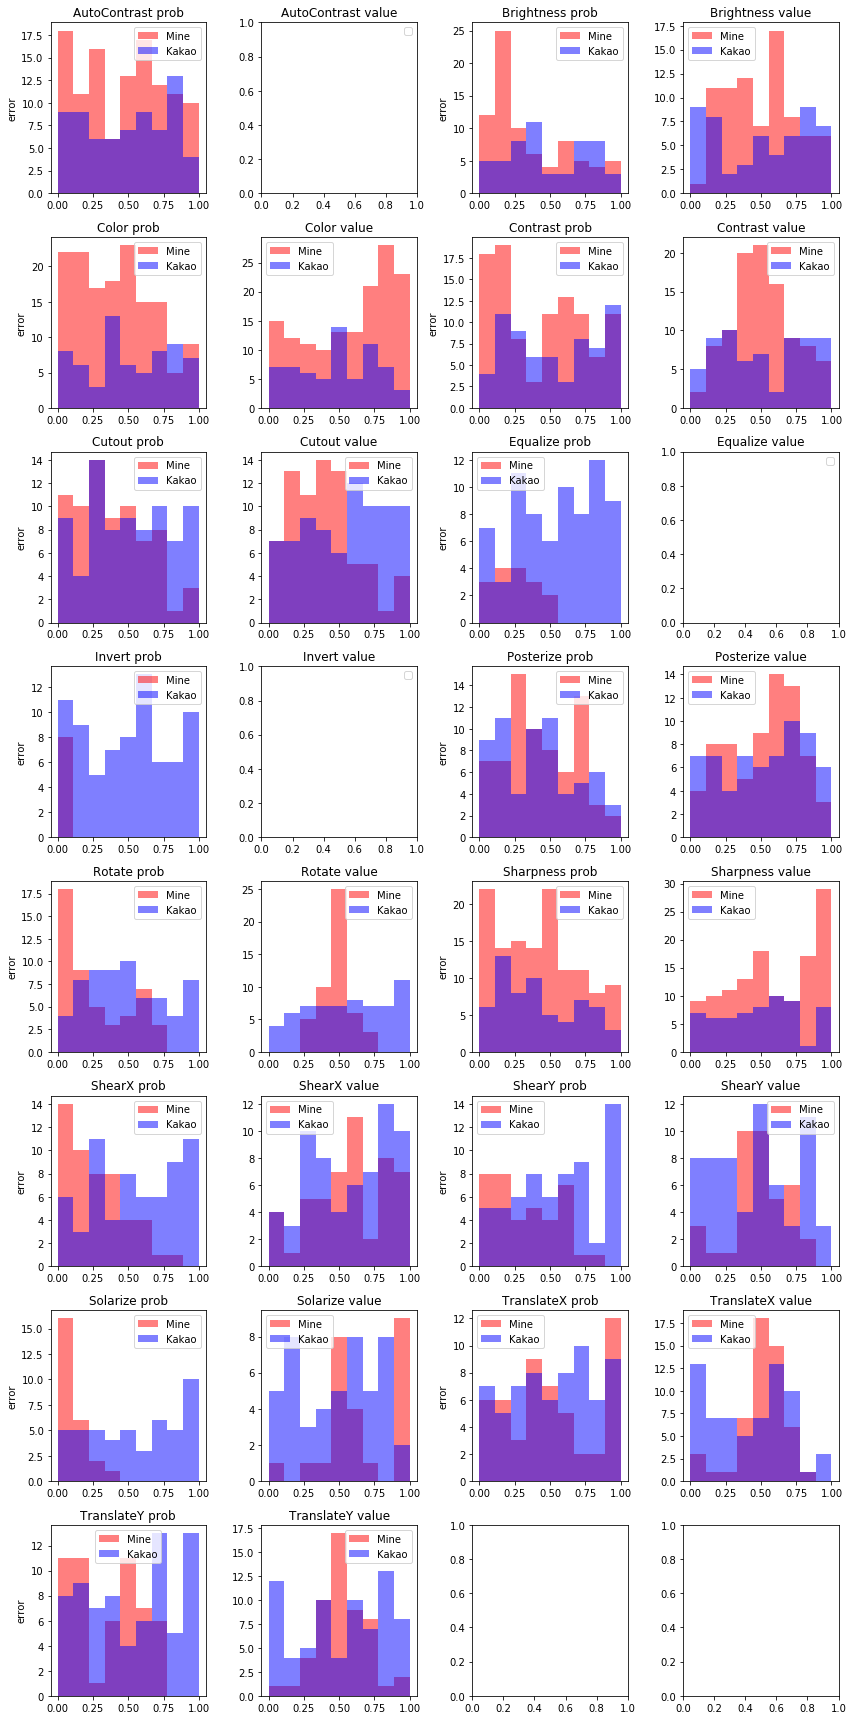

In [10]:
g = pivoted.groupby('op_name')

fig, ax = plt.subplots(8, 4, figsize=(12, 24), facecolor='white')

for idx, (label, data) in enumerate(g):
    
    nrow = idx // 2
    isEven = int((idx+1) % 2 == 0)
    
    ax[nrow, isEven*2].hist(optimal_policy_dict[label]['p'], bins=np.linspace(0, 1, 10), color='red', alpha=0.5, label='Mine')
    ax[nrow, isEven*2].hist(kakao_policy_dict[label]['p'], bins=np.linspace(0, 1, 10), color='blue', alpha=0.5, label='Kakao')
        
    if augmentation_list_to_explore[label]:
        ax[nrow, isEven*2+1].hist(optimal_policy_dict[label]['v'], bins=np.linspace(0, 1, 10), color='red', alpha=0.5, label='Mine')
        ax[nrow, isEven*2+1].hist(kakao_policy_dict[label]['v'], bins=np.linspace(0, 1, 10), color='blue', alpha=0.5, label='Kakao')
        
    ax[nrow, isEven*2].set_title(label + " prob")
    ax[nrow, isEven*2+1].set_title(label + " value")
    
    ax[nrow, isEven*2].set_ylabel("error")
    
    ax[nrow, isEven*2].legend()
    ax[nrow, isEven*2+1].legend()
    
plt.tight_layout()    
plt.show()